# Project: Classifying Heart Disease

- Dự đoán khả năng mắc bệnh tim

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns

import numpy as np
import pandas as pd
from PIL import Image
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torch import nn, optim

torch.manual_seed(1)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sns.set_style("whitegrid")
sns.despine()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Figure size 640x480 with 0 Axes>

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/heart_disease/heart_disease.csv").drop("Unnamed: 0", axis = 1)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,present
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,1
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,1
301,57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1


# Exploring the Dataset

In [ ]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,present
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  present   303 non-null    int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 33.3+ KB


=> Non isnull

In [ ]:
df.ca = df.ca.replace("?", str(3.0))
df.thal = df.thal.replace("?", str(6.0))

In [ ]:
df[["ca", "thal"]] = df[["ca", "thal"]].apply(lambda x: x.astype(float))

In [ ]:
df.corr()["present"].sort_values(ascending = False)

,present
present,1.000000
thal,0.523548
exang,0.431894
ca,0.426670
oldpeak,0.424510
cp,0.414446
slope,0.339213
sex,0.276816
age,0.223120
restecg,0.169202


In [ ]:
df.groupby("present").mean()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
present,,,,,,,,,,,,,
0,52.585366,0.560976,2.792683,129.250000,242.640244,0.140244,0.835366,158.378049,0.140244,0.586585,1.408537,0.323171,3.810976
1,56.625899,0.820144,3.589928,134.568345,251.474820,0.158273,1.172662,139.258993,0.546763,1.574101,1.827338,1.151079,5.841727


=> exang có tương quan cao. cp, slope, age có vẻ không có sự khác biệt lớn

# Dividing the Data

In [ ]:
X = df.drop("present", axis = 1)
y = df["present"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 47)

# Building the Model

In [ ]:
X_subset_train = X_train[["restecg", "thalach", "exang", "oldpeak", "age"]]

model = LogisticRegression()
model.fit(X_subset_train, y_train)

accuracy = model.score(X_subset_train, y_train)
print(f"Training accuracy: {accuracy:.2f}")

y_pred_t = model.predict(X_subset_train)

sensitivity = sum((y_train == 1) & (y_pred_t == 1)) / (sum((y_train == 1) & (y_pred_t == 1)) +
                                                       sum((y_train == 1) & (y_pred_t == 0)))
specificity = sum((y_train == 0) & (y_pred_t == 0)) / (sum((y_train == 0) & (y_pred_t == 0)) +
                                                       sum((y_train == 0) & (y_pred_t == 1)))
print(f"Training Sensitivity: {sensitivity:.2f}")
print(f"Training Specificity: {specificity:.2f}")

Training accuracy: 0.77
Training Sensitivity: 0.72
Training Specificity: 0.81


=> Độ đặc hiệu > độ nhạy, mô hình có xu hướng tốt hơn trong việc xác định các trường hợp không bị bệnh.

# Interpreting the Model Coefficients

In [ ]:
for name, coef in zip(["restecg", "thalach", "exang", "oldpeak", "age"],  model.coef_[0]):
    print(f"{name}: {round(np.exp(coef), 2)}")

restecg: 1.29
thalach: 0.98
exang: 4.32
oldpeak: 1.64
age: 1.03


=> Tất cả đặc trưng đều ít nhiều có quyết định đến tình trạng tim.

Phần trăm thay đổi = (odds ratio - 1) * 100%

- Cứ mỗi age tăng lên 1 đơn vị (tuổi) thì nguy cơ mắc bệnh tim là 3%.
- Khi oldpeak tăng, dẫn đến vấn đề về lưu thông máu đến tim, làm tăng nguy cơ lên 64%.
- Mỗi khi nhịp tim (thalach) tăng lên một nhịp, tỉ lệ mắc bệnh giảm -2%.
- Khả năng măc bệnh tim tăng 47% mỗi khi ECG nghỉ ngơi (restecg) tăng lên 1 đơn vị.
- Chỉ số cao nhất là đau ngực (exang), càng đau ngực, dẫn đến khó thở, máu không đổ lên tim gây ra nguy cơ cực lớn đến 332%.   
=> Vậy yếu tố gây ra tác động lớn nhất dẫn đến tình trạng tim của một người là chỉ số exang (đau ngực) và oldpeak (lưu thông máu).

# Final Model Evaluation

In [ ]:
X_subset_test = X_test[["restecg", "thalach", "exang", "oldpeak", "age"]]
model.fit(X_subset_train, y_train)

accuracy = model.score(X_subset_test, y_test)
print(f"Test accuracy: {accuracy:.2f}")

y_pred_test = model.predict(X_subset_test)

sensitivity = sum((y_test == 1) & (y_pred_test == 1)) / (sum((y_test == 1) & (y_pred_test == 1)) +
                                                       sum((y_test == 1) & (y_pred_test == 0)))
specificity = sum((y_test == 0) & (y_pred_test == 0)) / (sum((y_test == 0) & (y_pred_test == 0)) +
                                                       sum((y_test == 0) & (y_pred_test == 1)))
print(f"Test Sensitivity: {sensitivity:.2f}")
print(f"Test Specificity: {specificity:.2f}")

Test accuracy: 0.82
Test Sensitivity: 0.71
Test Specificity: 0.89


=> Độ đặc hiệu lớn hơn, vậy ta nên quan tâm về chẩn đoán không mặc bệnh hơn là mắc bệnh.

# Visualize

<Axes: ylabel='Count'>

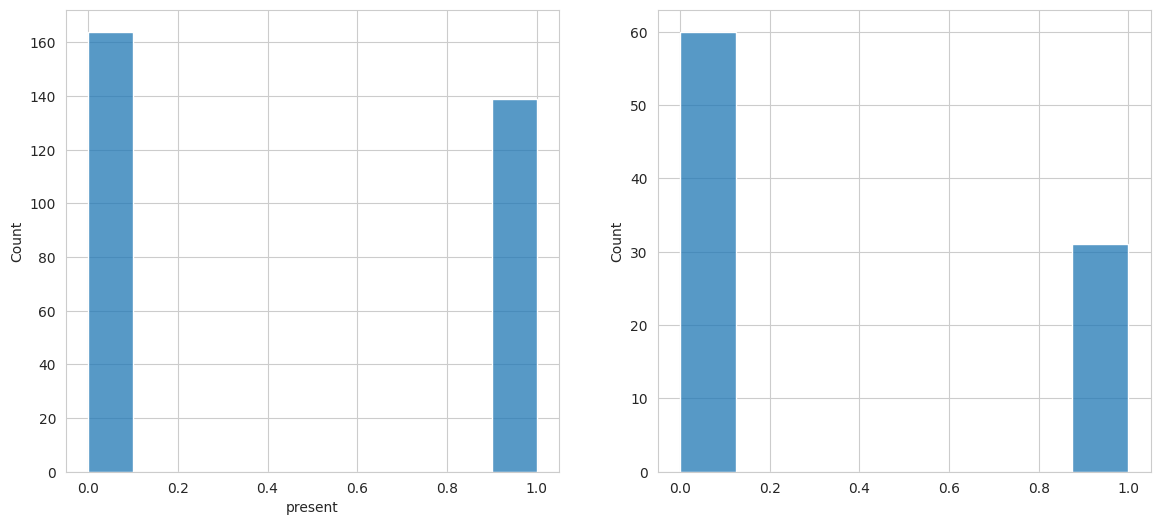

In [ ]:
plt.figure(figsize = (14, 6))

ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

sns.histplot(x = "present", data = df, ax = ax1)
sns.histplot(x = y_pred_test, ax = ax2)


# Deep Learning

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input, 1)
    def forward(self, x):
        output = self.linear(x)
        return output

class Data(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32)
        self.len = self.x.shape[0]
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

X = df.drop("present", axis = 1)
y = df["present"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 47)

scaler = StandardScaler()
X_train_subset = scaler.fit_transform(X_train[["restecg", "thalach", "exang", "oldpeak", "age"]].values)
X_test_subset = scaler.transform(X_test[["restecg", "thalach", "exang", "oldpeak", "age"]].values)

model = LogisticRegression(5)
# optimizer = optim.SGD(model.parameters(), lr = 0.1)
criterion = nn.BCEWithLogitsLoss()

train_loader = DataLoader(dataset = Data(X_train_subset, y_train.values), batch_size = 1)
test_loader = DataLoader(dataset = Data(X_test_subset, y_test.values), batch_size=1)

learning_rates = [0.00001, 0.0001, 0.001, 0.01]
MODELS = []
for lr in learning_rates:
    model = LogisticRegression(5)
    optimizer = optim.SGD(model.parameters(), lr = lr)
    for epoch in range(10):
        model.train()
        for x, y in train_loader:
            yhat = model(x)
            loss = criterion(yhat, y.reshape(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    MODELS.append(model)

for model in MODELS:
    correct_predictions = 0
    total_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            yhat = model(x)
            probabilities = torch.sigmoid(yhat)
            binary_predictions = (probabilities > 0.5).float()
            total_samples += len(y)
            correct_predictions += (y.float() == binary_predictions).sum().item()

    accuracy = correct_predictions / total_samples
    print("The accuracy", accuracy)

The accuracy 0.2459016393442623
The accuracy 0.6721311475409836
The accuracy 0.7049180327868853
The accuracy 0.8524590163934426


=> **Với Machine Learning thì test accuracy là 0.82 và Pytorch là 0.85. Cũng giống nhau gần như tuyệt đối. Các chỉ cố khác đều nằm trong khoảng 75% - 85%**

# Áp dụng các hàm kích hoạt khác nhau

In [ ]:
class Net_Sigmoid(nn.Module):
    def __init__(self, input, hidden, output):
        super(Net_Sigmoid, self).__init__()
        self.linear1 = nn.Linear(input, hidden)
        self.linear2 = nn.Linear(hidden, output)
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = self.linear2(x)
        return x

class Net_Tanh(nn.Module):
    def __init__(self, input, hidden, output):
        super(Net_Tanh, self).__init__()
        self.linear1 = nn.Linear(input, hidden)
        self.linear2 = nn.Linear(hidden, output)
    def forward(self, x):
        x = torch.tanh(self.linear1(x))
        x = self.linear2(x)
        return x

class Net_Relu(nn.Module):
    def __init__(self, input, hidden, output):
        super(Net_Relu, self).__init__()
        self.linear1 = nn.Linear(input, hidden)
        self.linear2 = nn.Linear(hidden, output)
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = self.linear2(x)
        return x

class Data(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32)
        self.length = x.shape[0]
    def __len__(self):
        return self.length
    def __getitem__(self, index):
        return self.x[index], self.y[index]


def model(model, epochs, criterion):
    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            yhat = model(x)
            loss = criterion(yhat, y.reshape(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            yhat = model(x)
            probability = torch.sigmoid(yhat)
            prediction = (probability > 0.5).float()
            y_pred.extend(prediction.detach().numpy())
            y_true.extend(y.reshape(-1, 1))

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

model_sigmoid = Net_Sigmoid(5, 9, 1)
criterion = nn.BCEWithLogitsLoss()
result_Sigmoid = model(model_sigmoid, 10, criterion)

model_tanh = Net_Tanh(5, 9, 1)
result_Tanh = model(model_tanh, 10, criterion)

model_relu = Net_Relu(5, 9, 1)
result_Relu = model(model_relu, 10, criterion)

print("The accuracy Sigmoid: ", result_Sigmoid)
print("The accuracy Tanh: ", result_Tanh)
print("The accuracy Relu: ", result_Relu)

The accuracy Sigmoid:  0.819672131147541
The accuracy Tanh:  0.8524590163934426
The accuracy Relu:  0.819672131147541


### Visualization train_loader and test_loader

In [ ]:
# dictt = {'training_loss': [], 'test_accuracy': []}

# for epoch in range(20):
#     for x, y in train_loader:
#         yhat = model(x)
#         loss = criterion(yhat, y.reshape(-1, 1))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         dictt['training_loss'].append(loss.data.item())

#     correct_predictions = 0
#     total_samples = 0
#     model.eval()
#     with torch.no_grad():
#         for x, y in test_loader:
#             yhat = model(x)
#             probabilities = torch.sigmoid(yhat)
#             binary_predictions = (probabilities > 0.5).float()
#             total_samples += len(y)
#             correct_predictions += (y.float() == binary_predictions).sum().item()
#     accuracy = correct_predictions / total_samples
#     dictt['test_accuracy'].append(accuracy)
#     print(f"The accuracy {epoch}", accuracy)

In [ ]:
# sum_accuracy_and_mean = np.mean(dictt["test_accuracy"])
# sum_accuracy_and_mean

=> Đây chỉ là ước lượng vì sau mỗi epoch sum() và sau đó mean() nên chưa phải là sự chắc chắn

In [ ]:
# plt.subplot(2, 1, 1)
# plt.plot(dictt['training_loss'], 'r')
# plt.ylabel('loss')
# plt.title('training loss iterations')

# plt.subplot(2, 1, 2)
# plt.plot(dictt['test_accuracy'])
# plt.ylabel('accuracy')
# plt.xlabel('epochs')
# plt.show()

=> Biểu đồ thứ 2 khá sát với loss, chỗ nhô cao thì cả 2 biểu đồ đều tương ứng, và ngược lại

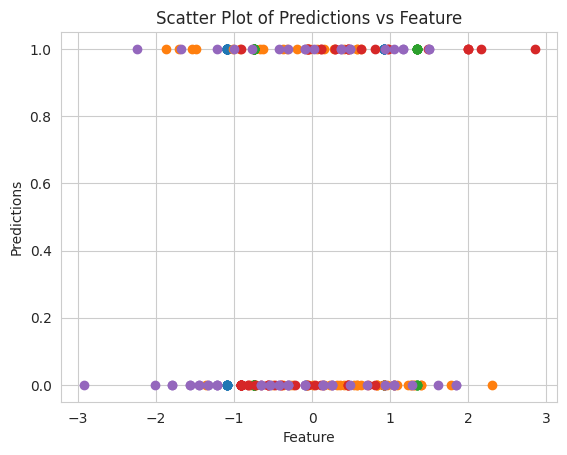

In [ ]:
feature_index = 0
for model, lr in zip(MODELS, learning_rates):
    yhat = model(torch.tensor(X_test_subset, dtype=torch.float32))
    probabilities = torch.sigmoid(yhat)
    binary_predictions = (probabilities > 0.5).float().detach().numpy()
    plt.scatter(X_test_subset[:, feature_index], binary_predictions, label=f"lr: {lr}")
    feature_index += 1

plt.scatter(X_test_subset[:, feature_index], np.array(y_test).reshape(-1, 1))
plt.xlabel("Feature")
plt.ylabel("Predictions")
plt.title("Scatter Plot of Predictions vs Feature")
plt.show()

### More hidden layer

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = self.linear3(x)
        return x

model = NeuralNetwork(input_size=5, hidden_size1=10, hidden_size2=5, output_size=1)
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(10):
    for x, y in train_loader:
        yhat = model(x)
        loss = criterion(yhat, y.reshape(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

correct_predictions = 0
total_samples = 0
with torch.no_grad():
    for x, y in test_loader:
        yhat = model(x)
        probabilities = torch.sigmoid(yhat)
        binary_predictions = (probabilities > 0.5).float()
        total_samples += len(y)
        correct_predictions += (y == binary_predictions).sum().item()

accuracy = correct_predictions / total_samples
print("The accuracy: ", accuracy)

The accuracy:  0.8032786885245902
